In [1]:
import pandas as pd
import numpy as np
import sys, os, time
import matplotlib.pyplot as plt
import seaborn as sns
import datajoint as dj
from scipy.special import erf # for psychometric functions

## INITIALIZE A FEW THINGS
sns.set(style="darkgrid", context="paper", font='Helvetica')
sns.set(style="darkgrid", context="paper", font_scale=1.4)
sns.set_style("darkgrid", {'xtick.bottom': True,'ytick.left': True, 'lines.markeredgewidth':0})

# import wrappers etc
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.utils import psychofit as psy
from ibl_pipeline.analyses import behavior as behavioral_analyses
from dj_tools import *

figpath  ='../Figures/'

Connecting zoe.ashwood@datajoint.internationalbrainlab.org:3306


In [2]:
sess = ((acquisition.Session & 'task_protocol LIKE "%trainingchoice%"') * \
 (behavioral_analyses.SessionTrainingStatus() & 'training_status="trained"'))

# sess = (acquisition.Session * \
#  (behavioral_analyses.SessionTrainingStatus() & 'training_status="trained"'))

s = pd.DataFrame.from_dict(sess.fetch(as_dict=True))
labs = list(s['session_lab'].unique())
labs.append('zadorlab')
print(labs)

['wittenlab', 'mainenlab', 'churchlandlab', 'angelakilab', 'cortexlab', 'danlab', 'mrsicflogellab', 'zadorlab']


In [3]:
# hack to get around SQL limit
for lidx, lab in enumerate(labs):

	print(lab)
	b = (behavior.TrialSet.Trial & (subject.SubjectLab() & 'lab_name="%s"'%lab)) \
		* sess.proj('session_uuid','task_protocol') \
		* subject.SubjectLab.proj('lab_name') \
		* subject.Subject() & 'subject_birth_date between "2018-09-01" and "2019-02-01"' & 'subject_line IS NULL OR subject_line="C57BL/6J"'

	bdat = pd.DataFrame(b.fetch(order_by='subject_nickname, session_start_time, trial_id'))
	print(bdat['subject_nickname'].unique())

	if lidx == 0:
		behav = bdat.copy()
	else:
		behav = behav.append(bdat.copy(), sort=False, ignore_index=True)

# ================================= #
# for now, manually add the cortexlab matlab animals
# ================================= #

ucl_mice = ['KS001', 'MW003', 'MW001', 'MW002', 'LEW008', 'LEW009', 'LEW010']
ucl_trained_dates = ['2019-02-25', '2018-12-10', '2019-02-11', '2019-01-14', '2018-10-04', '2018-10-04', 'LEW010']

for midx, mouse in enumerate(ucl_mice):

	print(mouse)
	sess = (acquisition.Session.proj('session_start_time', 'task_protocol', 'session_uuid', session_date='DATE(session_start_time)') & \
		'session_date > "%s"'%ucl_trained_dates[midx]) * behavioral_analyses.SessionTrainingStatus()
	b = ((behavior.TrialSet.Trial & (subject.SubjectLab() & 'lab_name="cortexlab"')) \
		* subject.SubjectLab.proj('lab_name') \
		* subject.Subject() & 'subject_nickname="%s"'%mouse) \
		* sess

	bdat  = pd.DataFrame(b.fetch(order_by='subject_nickname, session_start_time, trial_id'))
	behav = behav.append(bdat.copy(), sort=False, ignore_index=True)

wittenlab
['ibl_witten_04' 'ibl_witten_05' 'ibl_witten_06' 'ibl_witten_07']
mainenlab
['ZM_1084' 'ZM_1085' 'ZM_1086' 'ZM_1087' 'ZM_1089' 'ZM_1091' 'ZM_1092'
 'ZM_1093' 'ZM_1095' 'ZM_1097' 'ZM_1098' 'ZM_1367' 'ZM_1369' 'ZM_1371'
 'ZM_1372' 'ZM_1373']
churchlandlab
['CSHL_001' 'CSHL_002' 'CSHL_003' 'CSHL_005' 'CSHL_007' 'CSHL_008'
 'CSHL_010']
angelakilab
['IBL-T1' 'IBL-T2' 'IBL-T3' 'IBL-T4' 'NYU-01' 'NYU-02']
cortexlab
['KS003' 'KS005']
danlab
['DY_001' 'DY_002' 'DY_003']
mrsicflogellab
['IBL_002']
zadorlab
['CSK-IBL-003']
KS001
MW003
MW001
MW002
LEW008
LEW009
LEW010


In [4]:
# ================================= #
# convert
# ================================= #

behav = dj2pandas(behav)
behav['lab_name'] = behav['lab_name'].str.replace('zadorlab', 'churchlandlab')

In [10]:
behav.groupby(['probabilityLeft']).size().reset_index(name='Freq')

,probabilityLeft,Freq
0,0,190
1,10,372
2,20,50122
3,30,1040
4,40,1265
5,50,230871
6,60,1392
7,70,1181
8,80,50328
9,90,702


In [6]:
behav.groupby(['choice', 'trial_response_choice']).size().reset_index(name='Freq')

,choice,trial_response_choice,Freq
0,-1,CW,164517
1,0,No Go,1053
2,1,CCW,172630


    signed_contrast      ntrials  fraction
0              -100  1963.000000  0.116731
1               -50   536.666667  0.128192
2               -25  1848.250000  0.202415
3               -12  1862.875000  0.306708
4                -6  1728.750000  0.392050
5                 0  1986.750000  0.526605
6                 6  1739.000000  0.642821
7                12  1834.375000  0.748583
8                25  1853.375000  0.854406
9                50   522.000000  0.869688
10              100  1884.750000  0.923964
[-0.40600103 23.57243155  0.12500816  0.08805795]
-9184.597400142588
    signed_contrast     ntrials  fraction
0              -100  234.250000  0.095261
1               -50   24.333333  0.122222
2               -25  228.875000  0.177199
3               -12  245.875000  0.231262
4                -6  229.000000  0.317477
5                 0  223.375000  0.458087
6                 6  226.500000  0.653233
7                12  235.250000  0.788507
8                25  224.500000  0.86

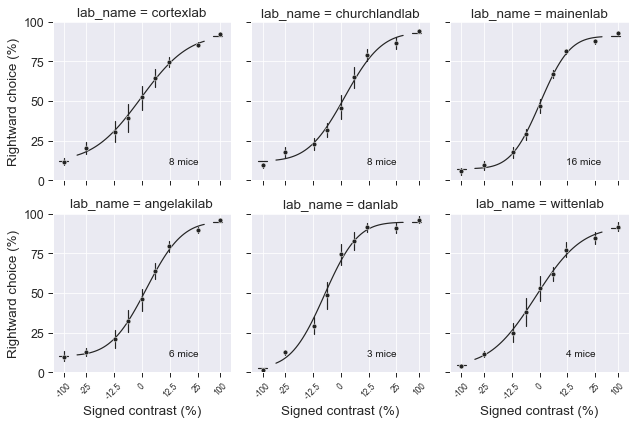

In [7]:
# ================================= #
# ONLY BLACK/neutral CURVES!
# ================================= #

sns.set_palette("gist_gray")  # palette for water types
fig = sns.FacetGrid(behav, 
	col="lab_name", col_order=['cortexlab', 'churchlandlab', 'mainenlab', 'angelakilab', 'danlab', 'wittenlab'], col_wrap=3,
	palette="gist_gray", sharex=True, sharey=True, aspect=1)
fig.map(plot_psychometric, "signed_contrast", "choice_right", "subject_nickname")

#fig.map(plot_chronometric, "signed_contrast", "rt")
fig.set_axis_labels('Signed contrast (%)', 'Rightward choice (%)')


In [ ]:

# FOR PARIS MEETING, ADD N IN TITLE
# titles = behav.groupby('lab_name').agg({'subject_nickname':'nunique', 'choice':
	# 'count'}).reset_index()      
# titles2 = ['%s | %d mice, %d trials'%(df['lab_name'], df['subject_nickname'], df['choice']) for i, df in titles.iterrows()]
# titles2 = ['%s lab'%(str.title(df['lab_name'][:-3])) for i, df in titles.iterrows()]
# # titles2 = [t.replace('Churchland lab', 'Churchland & Zador labs') for t in titles2]
# titles2 = [t.replace('Cortex lab', 'Carandini-Harris lab') for t in titles2]
titles2 = ['Carandini-Harris lab', 'Churchland & Zador labs', 'Mainen lab', 'Angelaki lab', 'Dan lab', 'Witten lab']

for ax, title in zip(fig.axes.flat, titles2):
    ax.set_title(title)
fig.despine(trim=True)
fig.savefig(os.path.join(figpath, "psychfuncs_summary.pdf"))
fig.savefig(os.path.join(figpath, "psychfuncs_summary.png"), dpi=600)
plt.close('all')

In [ ]:
# grab only example subjects from datajoint
import pandas as pd
import datajoint as dj

# snippet to get data you need
# sess_training = (acquisition.Session & 'task_protocol NOT LIKE "%biased%"')
sess_stable   = (acquisition.Session & 'task_protocol LIKE "%biased%"')

example_mice  = [{'subject_nickname': 'CSHL_005'}, {'subject_nickname': 'CSHL_007'}, 
	{'subject_nickname': 'IBL-T1'}, {'subject_nickname':'IBL-T4'}, 
	{'subject_nickname': 'ibl_witten_04'}, {'subject_nickname':'ibl_witten_05'}]

# behavior_training = (behavior.TrialSet.Trial & (subject.Subject & example_mice)) \
# 	* sess_training.proj('session_uuid','task_protocol') * subject.Subject.proj('subject_nickname') \
# 	* subject.SubjectLab.proj('lab_name')
behavior_stable = (behavior.TrialSet.Trial & (subject.Subject & example_mice)) \
	* sess_stable.proj('session_uuid','task_protocol') * subject.Subject.proj('subject_nickname') \
	* subject.SubjectLab.proj('lab_name')
data = pd.DataFrame(behavior_training.fetch(order_by='subject_nickname, session_start_time, trial_id'))

In [ ]:
behavior_stable